## Introduction

In regards to individuals who are both unable to cook and do not wish to step outside their dwellings for whatever reason, the emergence of food delivery apps has proved a blessing. Although food deliveries have always had a presence in the restaurant industry, these apps have made it so that whether it be a pizza or Chinese takeout, for instance, one can easily receive any dish or order to their liking to an unprecedented degree. 

Of course, it is unfortunately not always the case that these deliveries are made precisely on time, with some orders taking far longer than initially anticipated. As such, predictive modeling can help determine not only a reasonable estimate of the delivery time but also the exact level of uncertainty that may be associated with a given order depending on certain variables and factors. 

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import random
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.model_selection import cross_validate
import xgboost as xgb

pl.Config.set_fmt_str_lengths(50)
random.seed(121923)
delivery_data = pl.read_csv('/Users/ryanquach/Downloads/delivery_data.csv')

In [41]:
delivery_data.head(n = 10)

ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
str,str,str,str,f64,f64,f64,f64,str,str,str,str,str,i64,str,str,str,str,str,str
"""0x4607 ""","""INDORES13DEL02 ""","""37""","""4.9""",22.745049,75.892471,22.765049,75.912471,"""19-03-2022""","""11:30:00""","""11:45:00""","""conditions Sunny""","""High """,2,"""Snack ""","""motorcycle ""","""0""","""No ""","""Urban ""","""(min) 24"""
"""0xb379 ""","""BANGRES18DEL02 ""","""34""","""4.5""",12.913041,77.683237,13.043041,77.813237,"""25-03-2022""","""19:45:00""","""19:50:00""","""conditions Stormy""","""Jam """,2,"""Snack ""","""scooter ""","""1""","""No ""","""Metropolitian ""","""(min) 33"""
"""0x5d6d ""","""BANGRES19DEL01 ""","""23""","""4.4""",12.914264,77.6784,12.924264,77.6884,"""19-03-2022""","""08:30:00""","""08:45:00""","""conditions Sandstorms""","""Low """,0,"""Drinks ""","""motorcycle ""","""1""","""No ""","""Urban ""","""(min) 26"""
"""0x7a6a ""","""COIMBRES13DEL02 ""","""38""","""4.7""",11.003669,76.976494,11.053669,77.026494,"""05-04-2022""","""18:00:00""","""18:10:00""","""conditions Sunny""","""Medium """,0,"""Buffet ""","""motorcycle ""","""1""","""No ""","""Metropolitian ""","""(min) 21"""
"""0x70a2 ""","""CHENRES12DEL01 ""","""32""","""4.6""",12.972793,80.249982,13.012793,80.289982,"""26-03-2022""","""13:30:00""","""13:45:00""","""conditions Cloudy""","""High """,1,"""Snack ""","""scooter ""","""1""","""No ""","""Metropolitian ""","""(min) 30"""
"""0x9bb4 ""","""HYDRES09DEL03 ""","""22""","""4.8""",17.431668,78.408321,17.461668,78.438321,"""11-03-2022""","""21:20:00""","""21:30:00""","""conditions Cloudy""","""Jam """,0,"""Buffet ""","""motorcycle ""","""1""","""No ""","""Urban ""","""(min) 26"""
"""0x95b4 ""","""RANCHIRES15DEL01 ""","""33""","""4.7""",23.369746,85.33982,23.479746,85.44982,"""04-03-2022""","""19:15:00""","""19:30:00""","""conditions Fog""","""Jam """,1,"""Meal ""","""scooter ""","""1""","""No ""","""Metropolitian ""","""(min) 40"""
"""0x9eb2 ""","""MYSRES15DEL02 ""","""35""","""4.6""",12.352058,76.60665,12.482058,76.73665,"""14-03-2022""","""17:25:00""","""17:30:00""","""conditions Cloudy""","""Medium """,2,"""Meal ""","""motorcycle ""","""1""","""No ""","""Metropolitian ""","""(min) 32"""
"""0x1102 ""","""HYDRES05DEL02 ""","""22""","""4.8""",17.433809,78.386744,17.563809,78.516744,"""20-03-2022""","""20:55:00""","""21:05:00""","""conditions Stormy""","""Jam """,0,"""Buffet ""","""motorcycle ""","""1""","""No ""","""Metropolitian ""","""(min) 34"""


## Data Cleaning

To clean the dataset, this project performs various processes to achieve such goal. For example, it combines the longitude and latitude columns into a single distance column, and it removes columns that are either redundant or lack sufficient information about them. Moreover, it renames the dataset columns so that they are both aesthetically pleasing and lower-case, with a similar step being taken for the values of the categorical variables, and the notebook also prepares many of the columns for the upcoming imputation process. 

In [42]:
def haversine(long_start, lat_start, long_end, lat_end):
    long_start, lat_start, long_end, lat_end = map(np.radians, [long_start, lat_start, long_end, lat_end])
    
    long_dist = long_end - long_start 
    lat_dist = lat_end - lat_start 
    a = np.sin(lat_dist/2) ** 2 + np.cos(lat_start) * np.cos(lat_end) * np.sin(long_dist/2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    
    km = 6371 * c
    return km

delivery_data = (delivery_data
                .select(pl.exclude(['ID', 'Delivery_person_ID', 'Vehicle_condition', 'Order_Date', 
                                    'Time_Orderd', 'Time_Order_picked', 'multiple_deliveries']))
                .select(pl.all().name.map(lambda col_name: col_name.lower()))
                .rename({'restaurant_latitude': 'orig_lat',
                         'restaurant_longitude': 'orig_long',
                         'delivery_location_latitude': 'dest_lat',
                         'delivery_location_longitude': 'dest_long',
                         'weatherconditions': 'weather',
                         'road_traffic_density': 'traffic_density',
                         'time_taken(min)': 'time_taken'})
                .with_columns([abs(pl.col('orig_lat')).alias('orig_lat'),
                               abs(pl.col('orig_long')).alias('orig_long')])
                .with_columns([pl.col('weather').str.to_lowercase().str.replace('conditions ', ''),
                               pl.col('type_of_order').str.to_lowercase().str.strip_chars(),
                               pl.col('traffic_density').str.to_lowercase().str.strip_chars(),
                               pl.col('type_of_vehicle').str.strip_chars(),
                               pl.col('festival').str.to_lowercase().str.strip_chars(),
                               pl.col('city').str.to_lowercase().str.strip_chars(),
                               pl.col('time_taken').str.replace('\(min\) ', '')])    
                .with_columns(haversine(pl.col('orig_long'), pl.col('orig_lat'), 
                                        pl.col('dest_long'), pl.col('dest_lat')).alias('distance').round(2))
                .with_columns([pl.col('delivery_person_age').str.replace('NaN ', '10000').cast(pl.Int16),
                               pl.col('delivery_person_ratings').str.replace('NaN ', '10000').cast(pl.Float32),
                               pl.col('distance').str.replace('NaN ', '10000').cast(pl.Float32).round(2),
                               pl.col('time_taken').str.replace('NaN ', '10000').cast(pl.Int16)])
                .select(pl.exclude(['orig_lat', 'orig_long', 'dest_lat', 'dest_long']))
                .select(pl.exclude('time_taken'), pl.col('time_taken'))
                )

## Data Imputation

In [43]:
delivery_data = (delivery_data
                 .with_columns([pl.col(pl.Int16).replace({10000: None}),
                                pl.col(pl.Float32).replace({10000: None}),
                                pl.col(pl.Utf8).replace({'nan': None})])
                )

In [44]:
delivery_data.select(pl.all().is_null().sum())

delivery_person_age,delivery_person_ratings,weather,traffic_density,type_of_order,type_of_vehicle,festival,city,distance,time_taken
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
1854,1908,616,601,0,0,228,1200,0,0


In [45]:
delivery_data = (delivery_data
                 .filter(~pl.col('weather').is_null(),
                         ~pl.col('traffic_density').is_null(),
                         ~pl.col('festival').is_null(),
                         ~pl.col('city').is_null())
                 .with_columns([pl.col('delivery_person_age').fill_null(strategy = 'mean'),
                                pl.col('delivery_person_ratings').fill_null(strategy = 'mean')])
                )

In [46]:
delivery_data.select(pl.all().is_null().sum())

delivery_person_age,delivery_person_ratings,weather,traffic_density,type_of_order,type_of_vehicle,festival,city,distance,time_taken
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0


In [47]:
delivery_data.head(n = 10)

delivery_person_age,delivery_person_ratings,weather,traffic_density,type_of_order,type_of_vehicle,festival,city,distance,time_taken
i16,f32,str,str,str,str,str,str,f32,i16
37,4.9,"""sunny""","""high""","""snack""","""motorcycle""","""no""","""urban""",3.03,24
34,4.5,"""stormy""","""jam""","""snack""","""scooter""","""no""","""metropolitian""",20.18,33
23,4.4,"""sandstorms""","""low""","""drinks""","""motorcycle""","""no""","""urban""",1.55,26
38,4.7,"""sunny""","""medium""","""buffet""","""motorcycle""","""no""","""metropolitian""",7.79,21
32,4.6,"""cloudy""","""high""","""snack""","""scooter""","""no""","""metropolitian""",6.21,30
22,4.8,"""cloudy""","""jam""","""buffet""","""motorcycle""","""no""","""urban""",4.61,26
33,4.7,"""fog""","""jam""","""meal""","""scooter""","""no""","""metropolitian""",16.6,40
35,4.6,"""cloudy""","""medium""","""meal""","""motorcycle""","""no""","""metropolitian""",20.209999,32
22,4.8,"""stormy""","""jam""","""buffet""","""motorcycle""","""no""","""metropolitian""",19.98,34


In [48]:
delivery_data.describe()

describe,delivery_person_age,delivery_person_ratings,weather,traffic_density,type_of_order,type_of_vehicle,festival,city,distance,time_taken
str,f64,f64,str,str,str,str,str,str,f64,f64
"""count""",43592.0,43592.0,"""43592""","""43592""","""43592""","""43592""","""43592""","""43592""",43592.0,43592.0
"""null_count""",0.0,0.0,"""0""","""0""","""0""","""0""","""0""","""0""",0.0,0.0
"""mean""",29.579097,4.633897,null,null,null,null,null,null,9.760904,26.476487
"""std""",5.679158,0.31039,null,null,null,null,null,null,5.610426,9.346277
"""min""",20.0,2.5,"""cloudy""","""high""","""buffet""","""electric_scooter""","""no""","""metropolitian""",1.47,10.0
"""25%""",25.0,4.5,null,null,null,null,null,null,4.66,19.0
"""50%""",29.0,4.7,null,null,null,null,null,null,9.22,26.0
"""75%""",34.0,4.8,null,null,null,null,null,null,13.68,33.0
"""max""",39.0,5.0,"""windy""","""medium""","""snack""","""scooter""","""yes""","""urban""",20.969999,54.0


## Data Visualization

### Univariate Plots

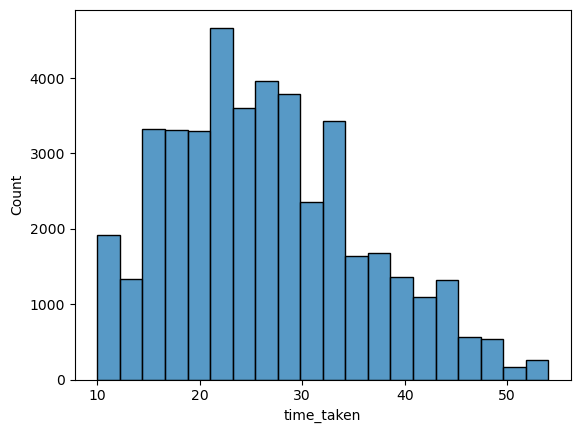

In [49]:
sns.histplot(data = delivery_data.to_pandas(), x = 'time_taken', bins = 20);

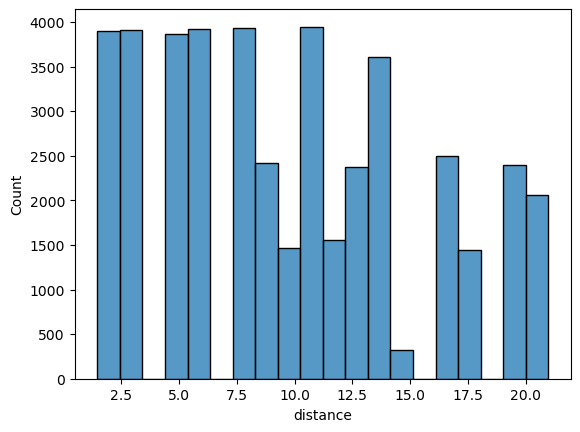

In [50]:
sns.histplot(data = delivery_data.to_pandas(), x = 'distance', bins = 20);

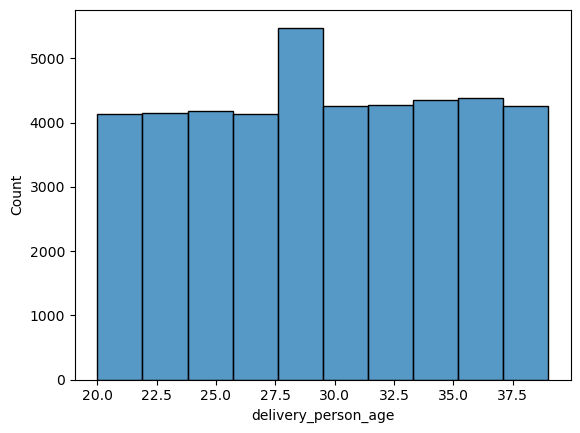

In [51]:
sns.histplot(data = delivery_data.to_pandas(), x = 'delivery_person_age', bins = 10);

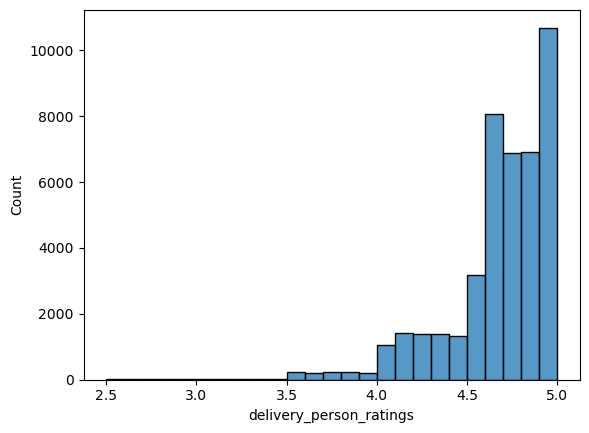

In [52]:
sns.histplot(data = delivery_data.to_pandas(), x = 'delivery_person_ratings', bins = 25);

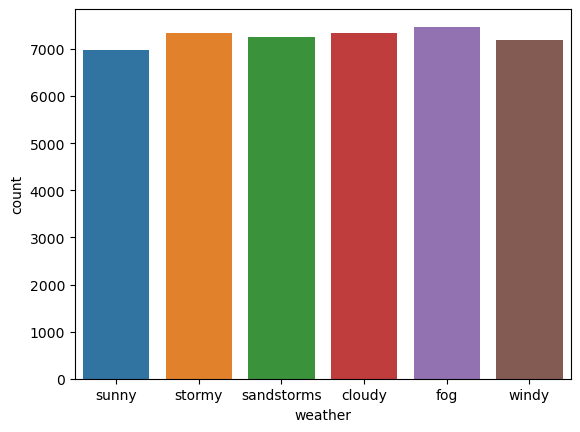

In [53]:
sns.countplot(data = delivery_data.to_pandas(), x = 'weather');

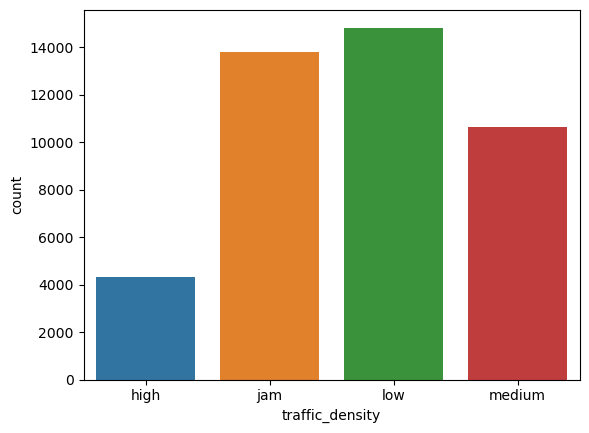

In [54]:
sns.countplot(data = delivery_data.to_pandas(), x = 'traffic_density');

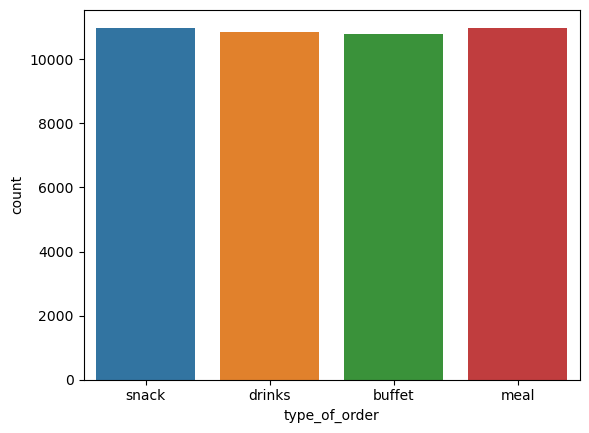

In [55]:
sns.countplot(data = delivery_data.to_pandas(), x = 'type_of_order');

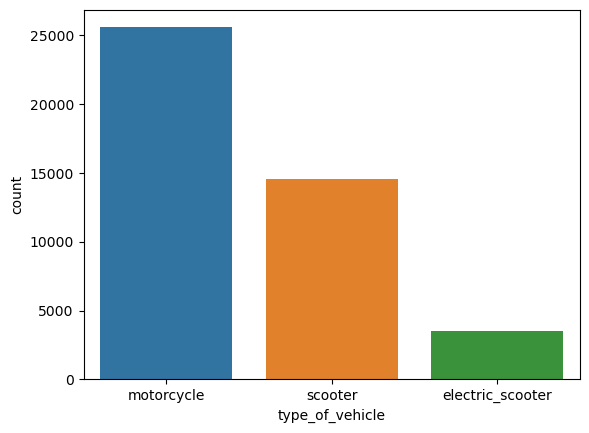

In [56]:
sns.countplot(data = delivery_data.to_pandas(), x = 'type_of_vehicle');

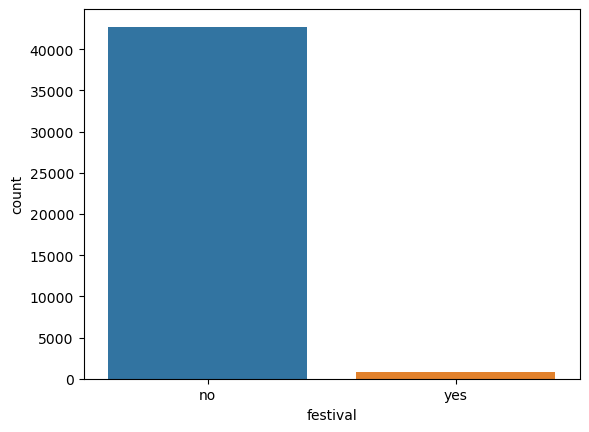

In [57]:
sns.countplot(data = delivery_data.to_pandas(), x = 'festival');

### Multivariate Plots

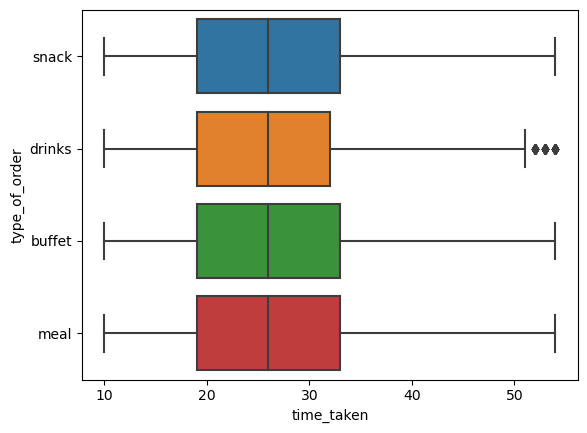

In [58]:
sns.boxplot(data = delivery_data.to_pandas(), x = 'time_taken', y = 'type_of_order');

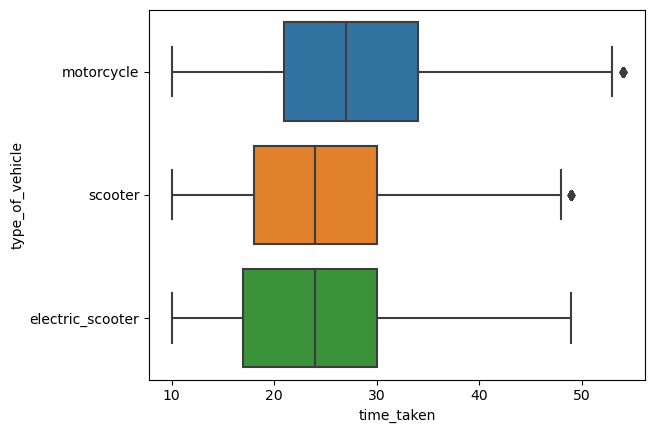

In [59]:
sns.boxplot(data = delivery_data.to_pandas(), x = 'time_taken', y = 'type_of_vehicle');

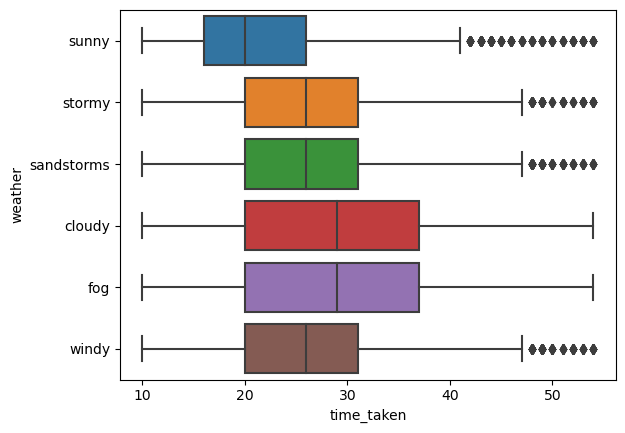

In [60]:
sns.boxplot(data = delivery_data.to_pandas(), x = 'time_taken', y = 'weather');

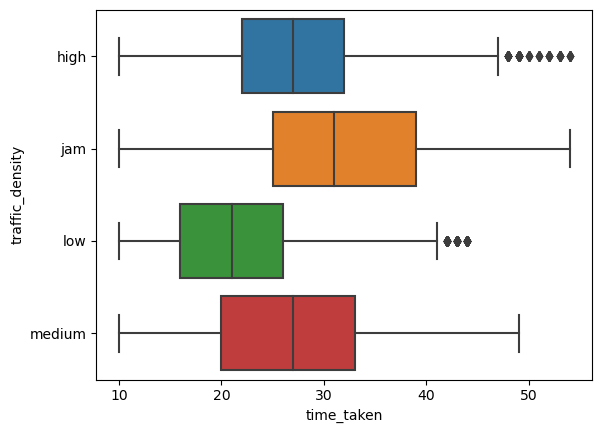

In [61]:
sns.boxplot(data = delivery_data.to_pandas(), x = 'time_taken', y = 'traffic_density');

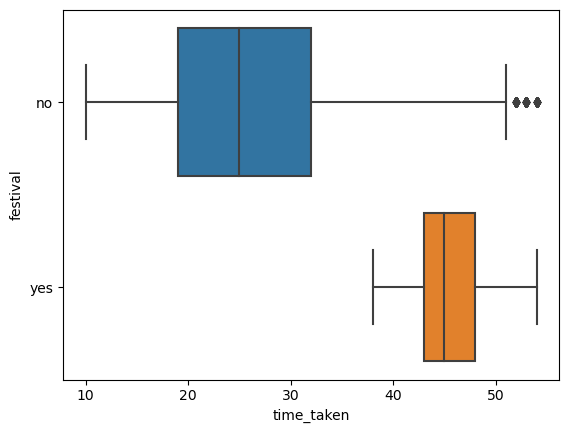

In [62]:
sns.boxplot(data = delivery_data.to_pandas(), x = 'time_taken', y = 'festival');

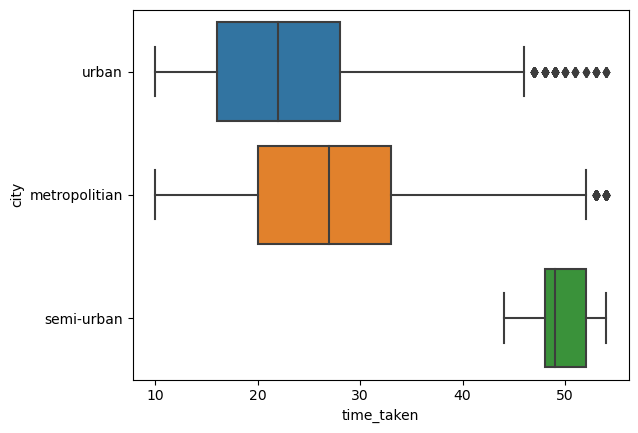

In [63]:
sns.boxplot(data = delivery_data.to_pandas(), x = 'time_taken', y = 'city');

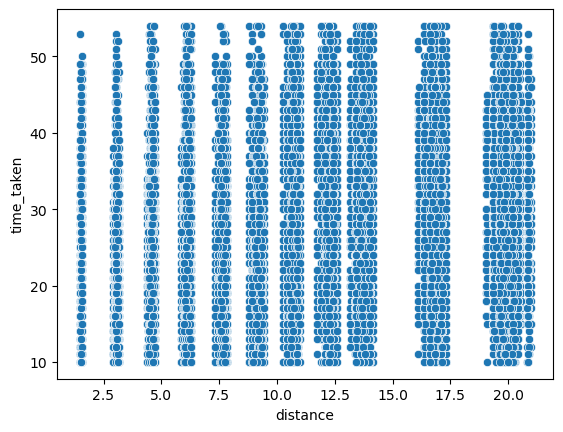

In [64]:
sns.scatterplot(data = delivery_data.to_pandas(), x = 'distance', y = 'time_taken');

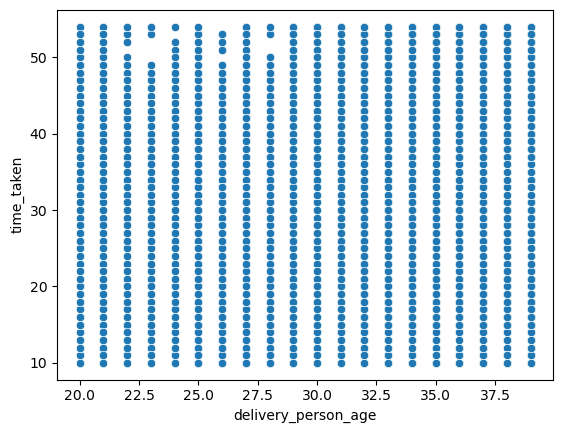

In [65]:
sns.scatterplot(data = delivery_data.to_pandas(), x = 'delivery_person_age', y = 'time_taken');

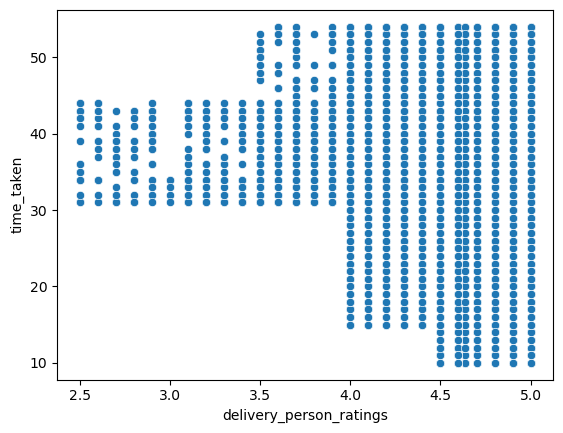

In [66]:
sns.scatterplot(data = delivery_data.to_pandas(), x = 'delivery_person_ratings', y = 'time_taken');

## Preparing Data for ML Process

In [67]:
data_matrix = delivery_data.to_dummies(pl.selectors.string(), drop_first = True)

In [68]:
data_matrix.head(n = 10)

delivery_person_age,delivery_person_ratings,weather_cloudy,weather_fog,weather_sandstorms,weather_stormy,weather_windy,traffic_density_jam,traffic_density_low,traffic_density_medium,type_of_order_buffet,type_of_order_drinks,type_of_order_meal,type_of_vehicle_electric_scooter,type_of_vehicle_scooter,festival_yes,city_metropolitian,city_semi-urban,distance,time_taken
i16,f32,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,f32,i16
37,4.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.03,24
34,4.5,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,20.18,33
23,4.4,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1.55,26
38,4.7,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,7.79,21
32,4.6,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,6.21,30
22,4.8,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,4.61,26
33,4.7,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,16.6,40
35,4.6,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,20.209999,32
22,4.8,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,19.98,34


In [69]:
X = data_matrix.select(pl.exclude('time_taken')).to_numpy()
Y = data_matrix.select(pl.col('time_taken')).to_numpy()

## Checking for Model Assumptions

In [70]:
mod_check = LinearRegression()
mod_check.fit(X, Y)
mod_pred = mod_check.predict(X)
mod_resid = Y - mod_pred
mod_SR = (mod_resid - np.mean(mod_resid))/np.std(mod_resid)

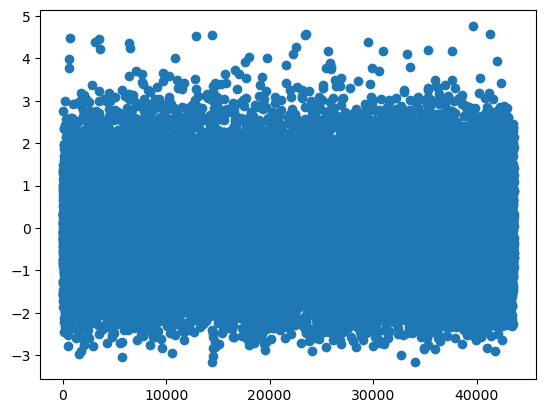

In [71]:
plt.scatter(x = np.arange(1, 43593), y = mod_SR);

In [72]:
print(np.mean(mod_SR))

1.1551203e-08


Given that the expectation of the residuals is approximately zero, that heteroskedasticity is not present, that there is no correlation of the residuals, and that there is linearity, one can conclude firmly that the conditions of Gauss-Markov Theorem are not violated here.  

It should be noted that these results were achieved in spite of individual scatterplots indicating that there was a lack of linearity. 

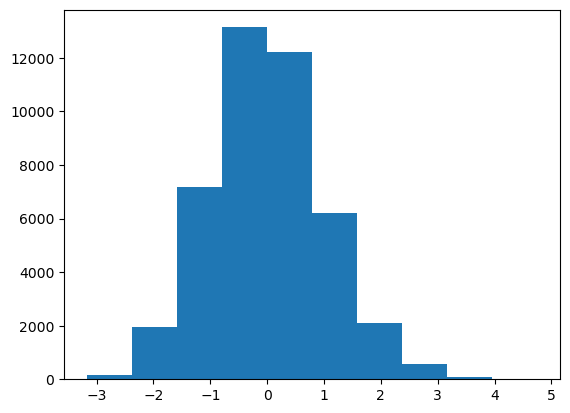

In [73]:
plt.hist(mod_SR);

Moreover, the histogram demonstrates that the residuals are approximately normally distributed, which means that statistical inference can be applied in this context. The purpose of this project is predictive, so this assumption is not as important, but it is still useful to be cognizant of this characteristic, as others may have different uses for the models. 

## Model Creation and Results

Five regression models will be used: OLS, lasso regression, ridge regression, gradient boosting, and lastly a random forest. The project will be performing five-fold cross validation, and to evaluate the models, it will use the scoring metrics of median absolute error, RMSE, and R-squared. Note that because all of the fitted models will employ the same amount of variables, adjusted R-squared is not an improvement over the standard R-squared value. 

In [74]:
mod_lm = LinearRegression()
mod_score = cross_validate(mod_lm, X, Y, 
                           scoring = ['neg_median_absolute_error', 'neg_root_mean_squared_error', 'r2'], 
                           cv = 5)
mod_score

{'fit_time': array([0.01703763, 0.01068282, 0.01027513, 0.00948405, 0.00859427]),
 'score_time': array([0.00168824, 0.00142312, 0.00152302, 0.00186515, 0.00141072]),
 'test_neg_median_absolute_error': array([-4.24453735, -4.20183563, -4.17062569, -4.1859045 , -4.23463345]),
 'test_neg_root_mean_squared_error': array([-6.32489681, -6.37451839, -6.33111238, -6.30524492, -6.37072182]),
 'test_r2': array([0.54484122, 0.53922188, 0.54010257, 0.5346122 , 0.53913232])}

In [75]:
mod_lasso = Lasso()
mod_score = cross_validate(mod_lasso, X, Y, 
                           scoring = ['neg_median_absolute_error', 'neg_root_mean_squared_error', 'r2'], 
                           cv = 5)
mod_score

{'fit_time': array([0.01185012, 0.00587106, 0.00713706, 0.00687313, 0.00680304]),
 'score_time': array([0.00320005, 0.00200915, 0.00249195, 0.00219989, 0.00142789]),
 'test_neg_median_absolute_error': array([-5.46805   , -5.60140991, -5.55072689, -5.41469574, -5.63298512]),
 'test_neg_root_mean_squared_error': array([-8.08835125, -8.14369678, -8.08729553, -8.00837994, -8.20321655]),
 'test_r2': array([0.2556519 , 0.24796125, 0.24957459, 0.24924114, 0.23586975])}

In [76]:
mod_ridge = Ridge()
mod_score = cross_validate(mod_ridge, X, Y, 
                           scoring = ['neg_median_absolute_error', 'neg_root_mean_squared_error', 'r2'], 
                           cv = 5)
mod_score

{'fit_time': array([0.00922871, 0.00567889, 0.00619817, 0.004884  , 0.00464797]),
 'score_time': array([0.001472  , 0.0022862 , 0.00151491, 0.00339603, 0.0014379 ]),
 'test_neg_median_absolute_error': array([-4.24519348, -4.20122528, -4.17199516, -4.18462753, -4.23502922]),
 'test_neg_root_mean_squared_error': array([-6.32484388, -6.37460947, -6.33091831, -6.30522251, -6.37091017]),
 'test_r2': array([0.54484882, 0.53920868, 0.54013079, 0.53461547, 0.53910505])}

In [77]:
mod_XGB = xgb.XGBRegressor()
mod_score = cross_validate(mod_XGB, X, Y, 
                           scoring = ['neg_median_absolute_error', 'neg_root_mean_squared_error', 'r2'], 
                           cv = 5)
mod_score

{'fit_time': array([2.69199395, 2.14119697, 2.21263099, 2.10528517, 2.28650784]),
 'score_time': array([0.01250291, 0.01260209, 0.01046395, 0.0101378 , 0.01004815]),
 'test_neg_median_absolute_error': array([-3.09621811, -3.07600784, -3.07055283, -3.03583145, -3.07055569]),
 'test_neg_root_mean_squared_error': array([-4.5862174 , -4.63489008, -4.66108322, -4.60650444, -4.62526035]),
 'test_r2': array([0.76068753, 0.75640074, 0.75072732, 0.75159856, 0.75707546])}

In [78]:
mod_rf = RandomForestRegressor()
mod_score = cross_validate(mod_rf, X, Y.ravel(), 
                           scoring = ['neg_median_absolute_error', 'neg_root_mean_squared_error', 'r2'], 
                           cv = 5)
mod_score

{'fit_time': array([10.79660511, 10.99072003, 11.41964698, 10.63363004, 10.01335907]),
 'score_time': array([0.26449704, 0.23014903, 0.23319006, 0.215832  , 0.22172594]),
 'test_neg_median_absolute_error': array([-3.08, -3.06, -3.05, -3.07, -3.07]),
 'test_neg_root_mean_squared_error': array([-4.79984052, -4.80690614, -4.8164411 , -4.84906468, -4.79932141]),
 'test_r2': array([0.73787427, 0.73798366, 0.73383348, 0.72475018, 0.73844762])}

In terms of accuracy, the best model appears to be the gradient boosting model when one looks at RMSE and R-squared. But for MAE, it appears that the best model is actually the random forest model. Following these two models, the OLS model and the ridge regression model appear to have approximately the same accuracy, with lasso regression being the worst model. 

For computational speed and complexity, the first three models were all similarly fast. The next slowest would be the gradient boosting model, with the fit time being about 200-300 times slower. However, the random forest model would even be slower, with the fit time taking 5 times longer the gradient boosting model, which should demonstrate the sheer difficulty that is associated with building a random forest model. 